In [2]:
%load_ext autoreload
%autoreload 2

import sys, os, pickle, time, warnings
import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

# Plotting modules
import matplotlib, corner
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [3]:
# Plotting modules
font = {'family' : 'serif', 'weight' : 'normal',
        'size'   : 16}
legend = {'fontsize': 16}
matplotlib.rc('font', **font)
matplotlib.rc('legend', **legend)
plt.rc('text', usetex=True)
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)

cm_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

corner_kwargs = {'max_n_ticks':3, 'title_kwargs':{"fontsize": 16}, 'label_kwargs':{'fontsize':16}}

In [260]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
from transformations import func_inv_jac, func_labels, label_dict

# Load disk Dwarf sample
Data generated in generate_population.py

In [13]:
size = 1000

In [14]:
sample = {}; true_pars={}; latent_pars={}; cmpt = 1
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = (hf['sample']['cmpt'][...]==cmpt)&\
                (hf['sample']['M'][...]>hf['true_pars'][str(cmpt)]['Mto'][...])
    subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset][subsample]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str): 
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]

In [6]:
true_params = np.array([np.log(size), -np.log(true_pars[str(cmpt)]['hz']), 
                        np.log(-true_pars['alpha1']), np.log(-true_pars['alpha2'])])
true_params

array([ 6.90775528, -0.64185389, -1.89711998, -1.2039728 ])

## Run with mockmodel code

In [7]:
import disk_halo_mstogap as dh_msto

In [8]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  10,          0.]])
labels = np.array( [r'$\log(\mathcal{N})$',  r'$\log(1/h_z)$', r'$\alpha_1$', r'$\alpha_2$'])

In [137]:
fid_pars = {'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']),
            'R0':true_pars['R0'],
            'free_pars':{}, 'fixed_pars':{}, 'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'models':[dh_msto.log_expmodel_grad], 'components':['halo'], 'ncomponents':1}

fid_pars['free_pars'][0] = ['w', 'hz']
fid_pars['free_pars']['shd'] = ['alpha1', 'alpha2']

fid_pars['fixed_pars'][0] = {'Mms':true_pars['Mms'], 'fD':1.-1e-15, 'alpha3':true_pars['0']['alpha3'],
                             'Mms1':true_pars['Mms1'], 'Mms2':true_pars['Mms2'], 
                             'Mto':true_pars[str(cmpt)]['Mto']}

print(' Free: ', fid_pars['free_pars'][0], ' Free shared: ', fid_pars['free_pars']['shd'], ' Fixed: ', fid_pars['fixed_pars'][0])

fid_pars['functions'][0] = {'hz':lambda x:np.exp(-x), 'alpha3':lambda x:x, 'w':lambda x: np.exp(x)}
fid_pars['functions_inv'][0] = {'hz':lambda x:-np.log(x), 'alpha3':lambda x: x, 'w':lambda x: np.log(x)}
fid_pars['jacobians'][0] = {'alpha3':lambda x:x, 'w':lambda x:x,'hz':lambda x:x}

fid_pars['functions']['shd'] = {'alpha1':lambda x: -np.exp(x), 'alpha2':lambda x: -np.exp(x)}
fid_pars['functions_inv']['shd'] = {'alpha1':lambda x: np.log(-x), 'alpha2':lambda x: np.log(-x)}
fid_pars['jacobians']['shd'] =  {'alpha1':lambda x:x, 'alpha2':lambda x:x}

sample_2d = np.vstack((1/sample['s'], np.log(1/sample['s']),
                         sample['sinb'], np.log(np.sqrt(1-sample['sinb']**2)), 
                         sample['m']))

poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_grad, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

 Free:  ['w', 'hz']  Free shared:  ['alpha1', 'alpha2']  Fixed:  {'Mms1': array(9.), 'Mms': array(8.), 'fD': 0.999999999999999, 'Mto': array(3.14), 'Mms2': array(7.), 'alpha3': array(-1.)}


In [138]:
def poisson_like(params, bounds=None, grad=False):

    poisson_kwargs = copy(poisson_kwargs_global)

    # Prior boundaries
    if bounds is None: bounds = poisson_kwargs['param_bounds']
    if np.sum((params<=bounds[0])|(params>=bounds[1]))>0:
        if grad: return -1e20, np.zeros(len(params))
        else: return -1e20

    # Optional prior inclusion
    if poisson_kwargs_global['model_prior'] is not None:
        prior=poisson_kwargs_global['model_prior'](params, fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    else: prior=0.

    integral = poisson_kwargs['model_integrate'](params, bins=poisson_kwargs['bins'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    obj = poisson_kwargs['logmodel'](poisson_kwargs['sample'], params, gmm=poisson_kwargs['gmm'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    if not grad: return np.sum(obj) - integral + prior

    elif grad:
        model_val = np.sum(obj[0]) - integral[0] + prior[0]
        model_grad = np.sum(obj[1], axis=1) - integral[1] + prior[1]
        return model_val, model_grad

In [139]:
bounds = np.array([[-10, -10,         -5., -5.],
                   [ 10,  10,          0.,  0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1,
                -np.random.rand()*1] )
p0

array([ 1.85474741, -1.27432876, -0.99841496, -0.23166057])

In [140]:
poisson_like(p0)

1129.599234727397

In [141]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

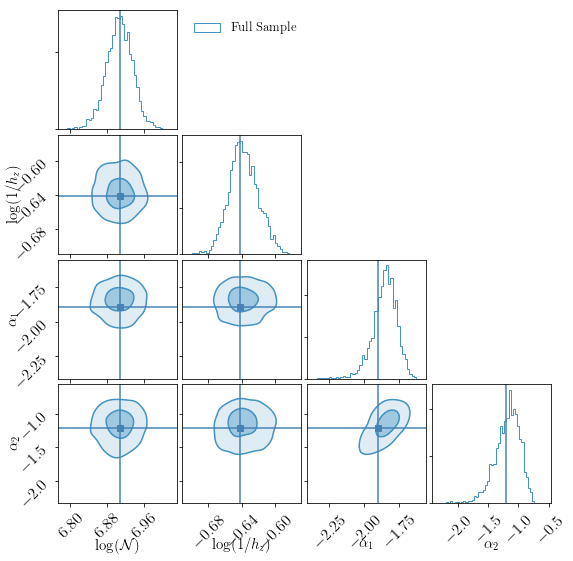

In [142]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

### Parallax error

In [143]:
sample_2d = np.vstack((sample['parallax_obs'], sample['parallax_error'], 
                       np.abs(sample['sinb']), np.log(np.sqrt(1-sample['sinb']**2)), 
                       sample['m'], np.log(sample['parallax_error'])))

fid_pars['models']=[dh_msto.log_expmodel_perr]
poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_perr, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

In [144]:
bounds = np.array([[-10, -10,         -5., -5.],
                   [ 10,  10,          0.,  0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1,
                -np.random.rand()*1] )
p0

array([-0.82543598, -1.60197895, -0.43045702, -0.73597185])

In [145]:
poisson_like(p0)

-3724.422433326451

In [146]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

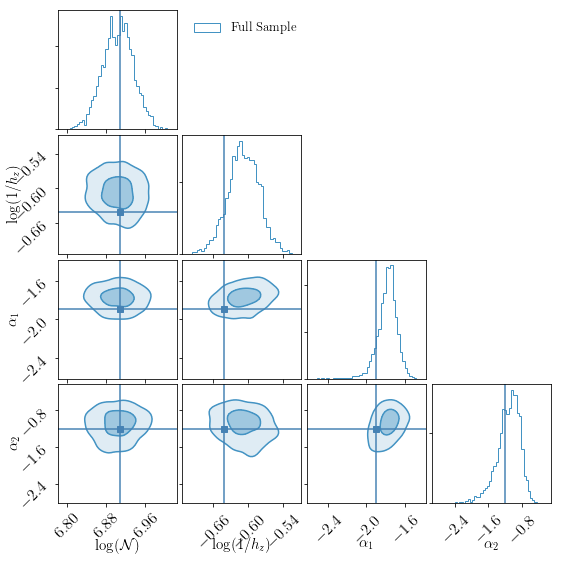

In [147]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

# Load halo Dwarf sample
Data generated in generate_population.py

In [148]:
size = 1000

In [149]:
sample = {}; true_pars={}; latent_pars={}; cmpt = 2
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = (hf['sample']['cmpt'][...]==cmpt)&\
                (hf['sample']['M'][...]>hf['true_pars'][str(cmpt)]['Mto'][...])
    subsample  = np.sort(np.random.choice(np.arange(np.sum(subset)), size=size, replace=False))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset][subsample]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str): 
            true_pars[key]=hf['true_pars'][key][...]
        else:
            true_pars[key]={}
            for par in hf['true_pars'][key].keys():
                true_pars[key][par]=hf['true_pars'][key][par][...]

In [150]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations

In [161]:
true_params = np.array([np.log(size), np.log(true_pars[str(cmpt)]['hz']/3-1),  
                        np.log(-true_pars['alpha1']), np.log(-true_pars['alpha2'])])
true_params

array([ 6.90775528, -0.62860866, -1.89711998, -1.2039728 ])

## Run with mockmodel code

In [162]:
import disk_halo_mstogap as dh_msto

In [163]:
bounds = np.array([[-10, -10,         -5.],
                   [ 10,  10,          0.]])
labels = np.array( [r'$\log(\mathcal{N})$',  r'$\log(h_z/3-1)$', r'$\alpha_1$', r'$\alpha_2$'])

In [164]:
fid_pars = {'Mmax':true_pars['Mx'],  'lat_min':np.deg2rad(true_pars['theta_deg']),
            'R0':true_pars['R0'],
            'free_pars':{}, 'fixed_pars':{}, 'functions':{}, 'functions_inv':{}, 'jacobians':{}, 'w':True,
            'models':[dh_msto.log_halomodel_grad], 'components':['halo'], 'ncomponents':1}

fid_pars['free_pars'][0] = ['w', 'hz']
fid_pars['free_pars']['shd'] = ['alpha1', 'alpha2']

fid_pars['fixed_pars'][0] = {'Mms':true_pars['Mms'], 'fD':1.-1e-15, 'alpha3':true_pars[str(cmpt)]['alpha3'],
                             'Mms1':true_pars['Mms1'], 'Mms2':true_pars['Mms2'], 
                             'Mto':true_pars[str(cmpt)]['Mto']}

print(' Free: ', fid_pars['free_pars'][0], ' Free shared: ', fid_pars['free_pars']['shd'], ' Fixed: ', fid_pars['fixed_pars'][0])

fid_pars['functions'][0] = {'hz':lambda x:3*(1+np.exp(x)), 'alpha3':lambda x:x, 'w':lambda x: np.exp(x)}
fid_pars['functions_inv'][0] = {'hz':lambda x:np.log(x/3 - 1), 'alpha3':lambda x: x, 'w':lambda x: np.log(x)}
fid_pars['jacobians'][0] = {'alpha3':lambda x:x, 'w':lambda x:x,'hz':lambda x:x}

fid_pars['functions']['shd'] = {'alpha1':lambda x: -np.exp(x), 'alpha2':lambda x: -np.exp(x)}
fid_pars['functions_inv']['shd'] = {'alpha1':lambda x: np.log(-x), 'alpha2':lambda x: np.log(-x)}
fid_pars['jacobians']['shd'] =  {'alpha1':lambda x:x, 'alpha2':lambda x:x}

sample_2d = np.vstack((1/sample['s'], np.log(1/sample['s']),
                         sample['sinb'], np.log(np.sqrt(1-sample['sinb']**2)), 
                         sample['m']))

poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_grad, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

 Free:  ['w', 'hz']  Free shared:  ['alpha1', 'alpha2']  Fixed:  {'Mms1': array(9.), 'Mms': array(8.), 'fD': 0.999999999999999, 'Mto': array(3.3), 'Mms2': array(7.), 'alpha3': array(-0.6)}


In [165]:
def poisson_like(params, bounds=None, grad=False):

    poisson_kwargs = copy(poisson_kwargs_global)

    # Prior boundaries
    if bounds is None: bounds = poisson_kwargs['param_bounds']
    if np.sum((params<=bounds[0])|(params>=bounds[1]))>0:
        if grad: return -1e20, np.zeros(len(params))
        else: return -1e20

    # Optional prior inclusion
    if poisson_kwargs_global['model_prior'] is not None:
        prior=poisson_kwargs_global['model_prior'](params, fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    else: prior=0.

    integral = poisson_kwargs['model_integrate'](params, bins=poisson_kwargs['bins'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    obj = poisson_kwargs['logmodel'](poisson_kwargs['sample'], params, gmm=poisson_kwargs['gmm'], fid_pars=poisson_kwargs['fid_pars'], grad=grad)
    if not grad: return np.sum(obj) - integral + prior

    elif grad:
        model_val = np.sum(obj[0]) - integral[0] + prior[0]
        model_grad = np.sum(obj[1], axis=1) - integral[1] + prior[1]
        return model_val, model_grad

In [166]:
bounds = np.array([[-10, -10,         -5., -5.],
                   [ 10,  10,          0.,  0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1,
                -np.random.rand()*1] )
p0

array([ 3.46439307,  1.33139131, -0.1131106 , -0.20765446])

In [167]:
poisson_like(p0)

-1214.42139560249

In [168]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

In [160]:
true_params

array([ 6.90775528, -1.5260563 , -1.89711998, -1.2039728 ])

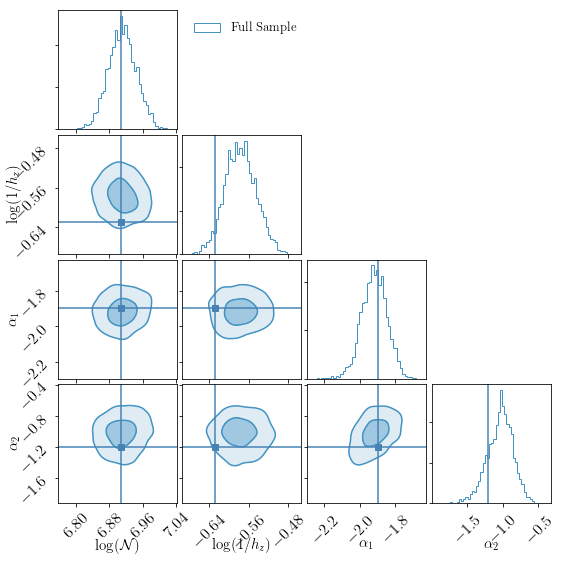

In [169]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

### Parallax error

In [223]:
sample_2d = np.vstack((sample['parallax_obs'], sample['parallax_error'], 
                       np.abs(sample['sinb']), np.log(np.sqrt(1-sample['sinb']**2)), 
                       sample['m'], np.log(sample['parallax_error'])))

fid_pars['models']=[dh_msto.log_halomodel_perr]
poisson_kwargs_global = {'sample':sample_2d,
                         'logmodel': dh_msto.logmodel_perr, 'model_integrate':dh_msto.integral_model,
                         'param_bounds':bounds, 'gmm':None, 'bins':([0,np.inf],[-np.inf,np.inf]),
                         'fid_pars':fid_pars, 'model_prior':None}

In [224]:
sample_2d.shape

(6, 1000)

In [225]:
bounds = np.array([[-10, -10,         -5., -5.],
                   [ 10,  10,          0.,  0.]])
poisson_kwargs_global['param_bounds']=bounds

p0 = np.array( [transformations.logit(np.random.rand()),
                transformations.logit(np.random.rand()),
                -np.random.rand()*1,
                -np.random.rand()*1] )
p0

array([-1.52587018, -2.24229533, -0.90374095, -0.31081989])

In [226]:
poisson_like(p0)

-4343.88980087223

In [227]:
sampler = samplers.run_mcmc_global(p0, poisson_like, bounds, nstep=1000,
                                 ncores=1, notebook='notebook')

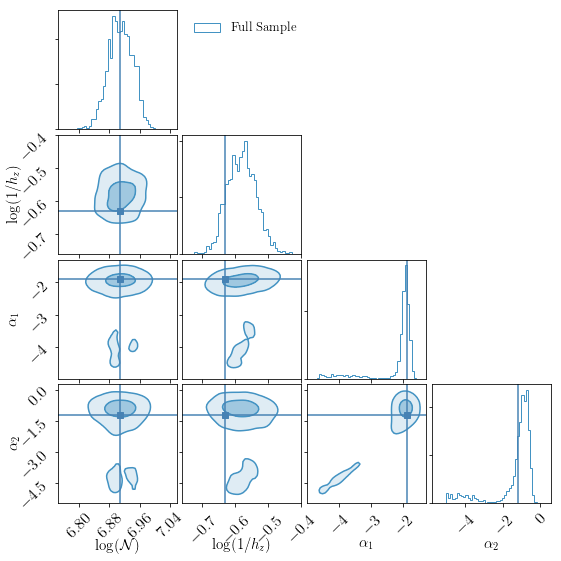

In [228]:
index = ['Full Sample']
plotting.layered_corners([sampler], labels=labels, index=index, truths=true_params,
                         colors=[cm.RdBu(0.8)])

# Load fits from Saved File

In [268]:
chains = {}; true_pars = {}; param_trans={}; free_pars={}
cmpt=0;
with h5py.File("/data/asfe2/Projects/mwtrace_data/mockmodel/fits_dwarfs_cmpt%d.h" % cmpt, 'r') as hf:
    for key in hf['chain'].keys():
        chains[key]=hf['chain'][key][...]
    for par in hf['true_pars'].keys():
        try: true_pars[par]=hf['true_pars'][par][...]
        except AttributeError:
            true_pars[par]={}
            for par2 in hf['true_pars'][par].keys():
                true_pars[par][par2]=hf['true_pars'][par][par2][...]
    for cmpt_local in hf['param_trans'].keys():
        param_trans[cmpt_local]={}
        for par in hf['param_trans'][cmpt_local].keys():
            param_trans[cmpt_local][par]=hf['param_trans'][cmpt_local][par][...].astype(str).tolist()
            for ii in range(1,5): param_trans[cmpt_local][par][ii]=float(param_trans[cmpt_local][par][ii])
    for cmpt_local in hf['free_pars'].keys():
        free_pars[cmpt_local]=np.array(hf['free_pars'][cmpt_local][...].astype(str))
        
#for j in range(3): true_pars[str(j)]['w']*=true_pars['N']
true_params=[]; params_i = 0
for i, cmpt_local in enumerate(free_pars.keys()):
    for par in free_pars[cmpt_local]:
        try: 
            true_params+=[func_inv_jac[param_trans[str([cmpt,'shd'][i])][par][0]](*param_trans[str([cmpt,'shd'][i])][par][1:3])[1](true_pars[str([cmpt,'shd'][i])][par]),]
        except KeyError: 
            true_params+=[func_inv_jac[param_trans[str([cmpt,'shd'][i])][par][0]](*param_trans[str([cmpt,'shd'][i])][par][1:3])[1](true_pars[par]),]
        params_i += 1;
true_params=np.array(true_params)

labels=[]; params_i = 0
for cmpt in free_pars.keys():
    for par in free_pars[cmpt]:
        labels+=[func_labels[param_trans[cmpt][par][0]](label_dict[par], *param_trans[cmpt][par][1:3]),]
        params_i += 1;

### Component 0

In [ ]:
index = ['No error', r'$\varpi$ error']
plotting.layered_corners([chains['full_noerr'], chains['full_perr']], index=index, truths=true_params, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

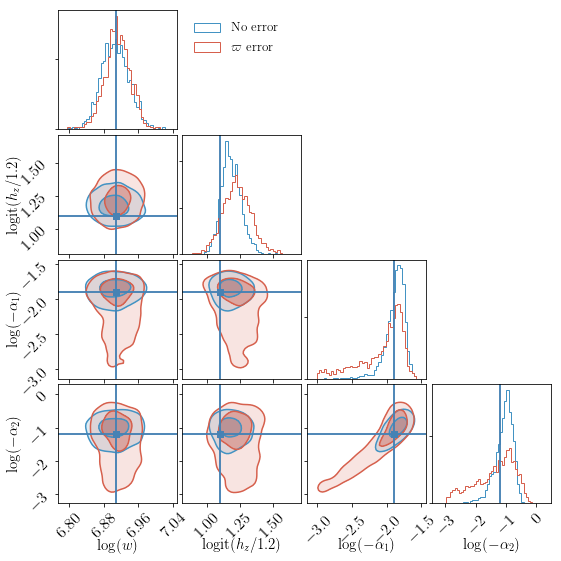

In [206]:
index = ['No error', r'$\varpi$ error']
plotting.layered_corners([chains['full_noerr'], chains['full_perr']], index=index, truths=true_params, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

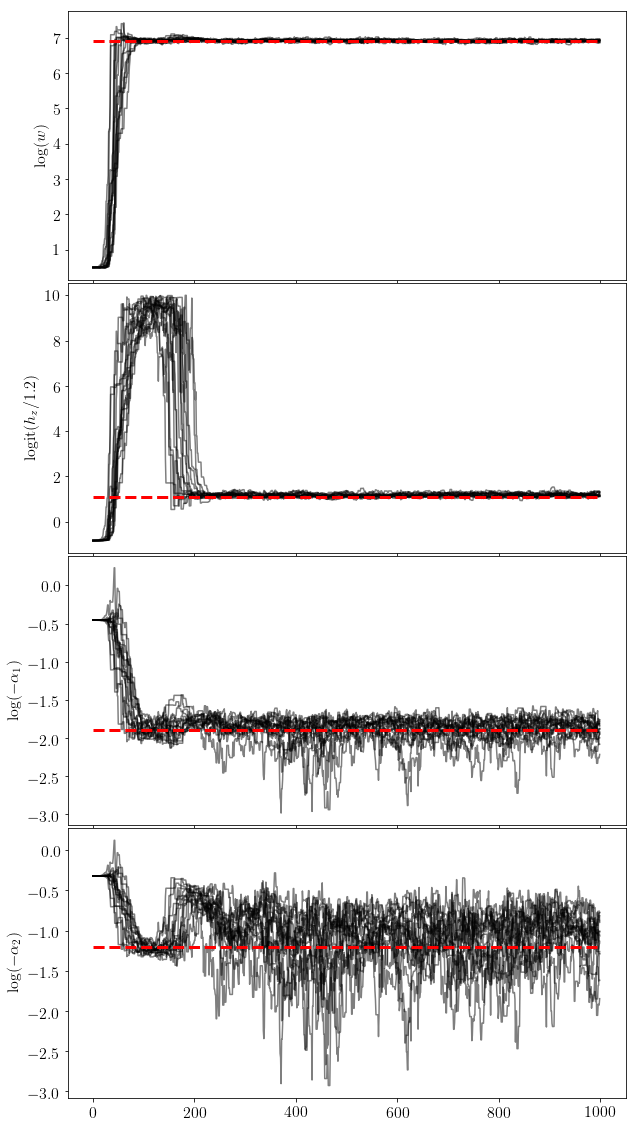

In [207]:
plotting.plot_chains(chains['full_noerr'], truths=true_params, labels=labels)

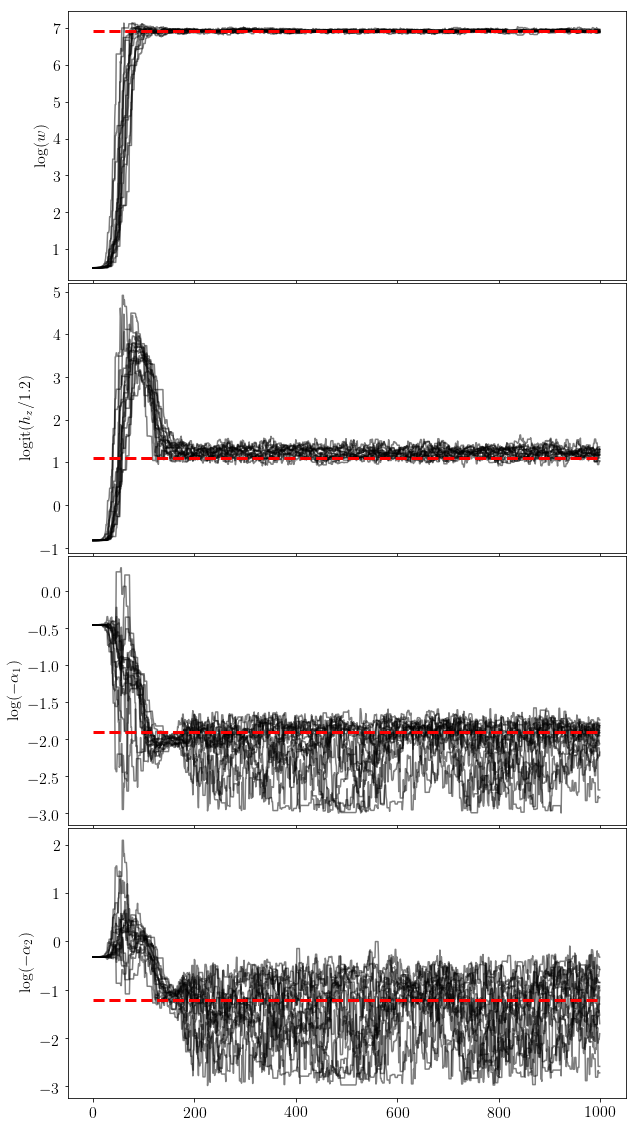

In [208]:
plotting.plot_chains(chains['full_perr'], truths=true_params, labels=labels)

### Component 1

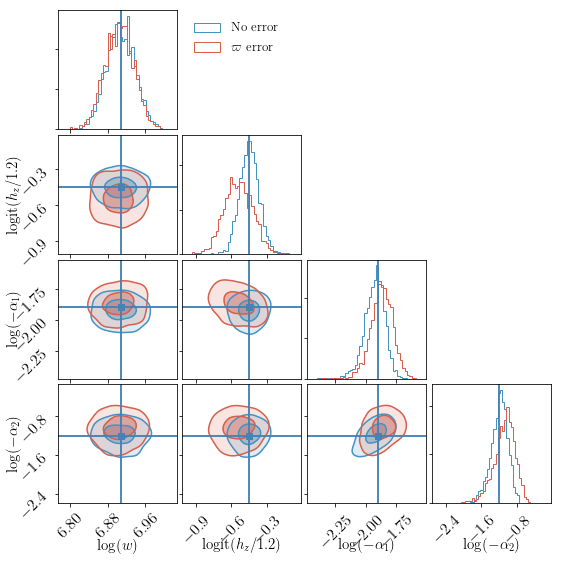

In [237]:
index = ['No error', r'$\varpi$ error']
plotting.layered_corners([chains['full_noerr'], chains['full_perr']], index=index, truths=true_params, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

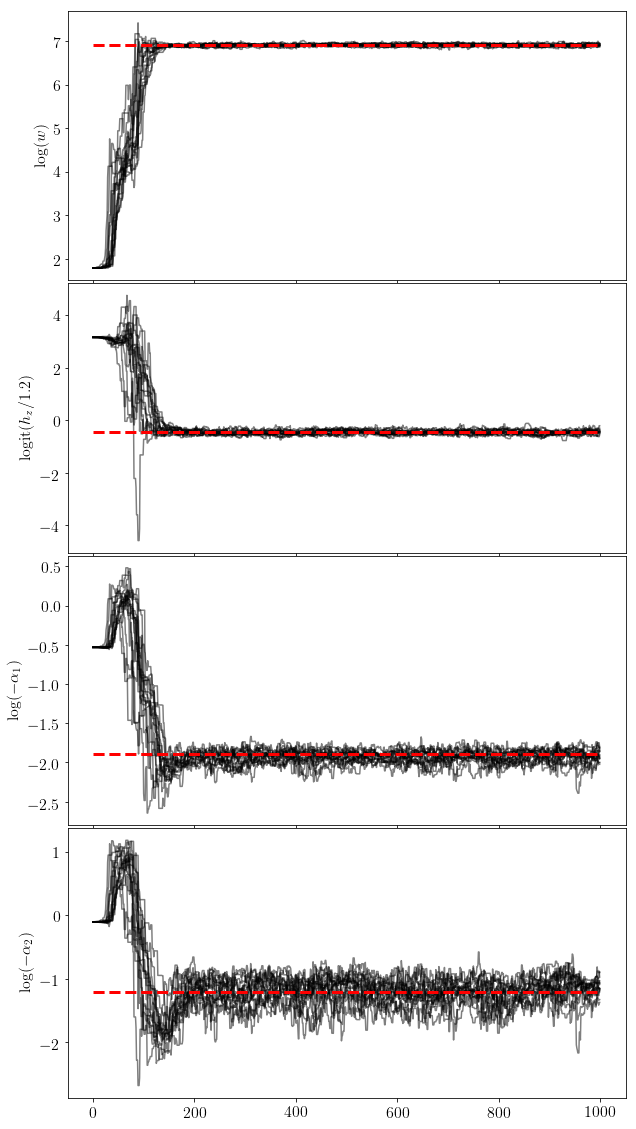

In [238]:
plotting.plot_chains(chains['full_noerr'], truths=true_params, labels=labels)

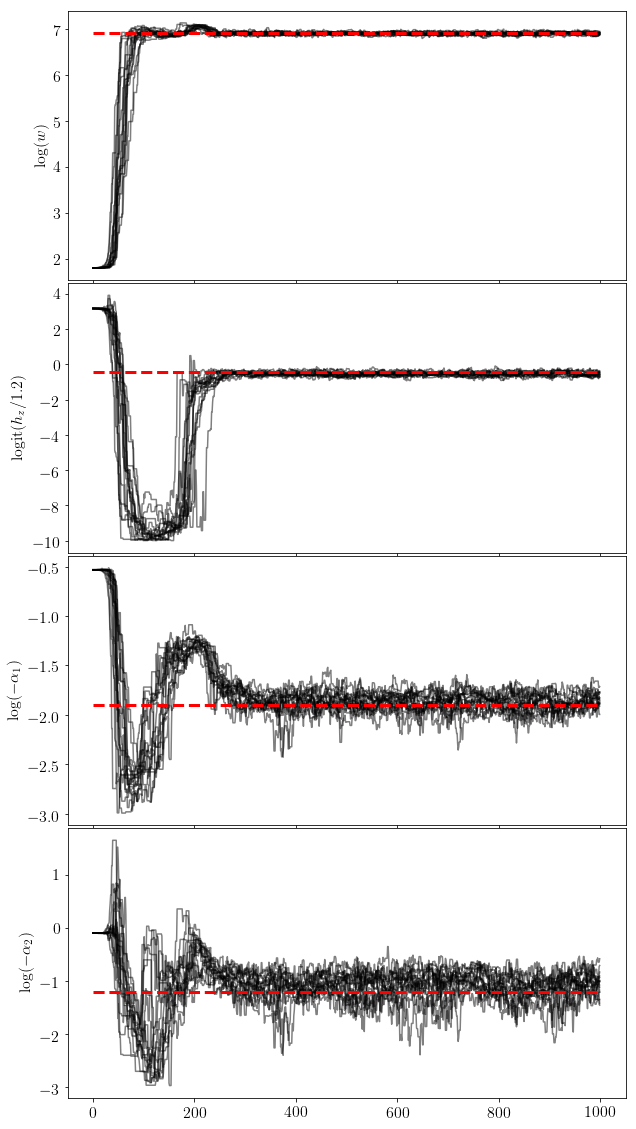

In [239]:
plotting.plot_chains(chains['full_perr'], truths=true_params, labels=labels)

### Component 2

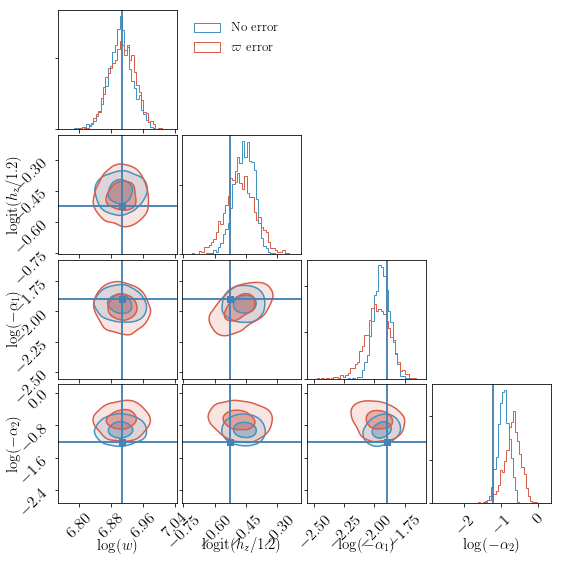

In [253]:
index = ['No error', r'$\varpi$ error']
plotting.layered_corners([chains['full_noerr'], chains['full_perr']], index=index, truths=true_params, labels=labels,
                         colors=[cm.RdBu(0.8), cm.RdBu(0.2)])

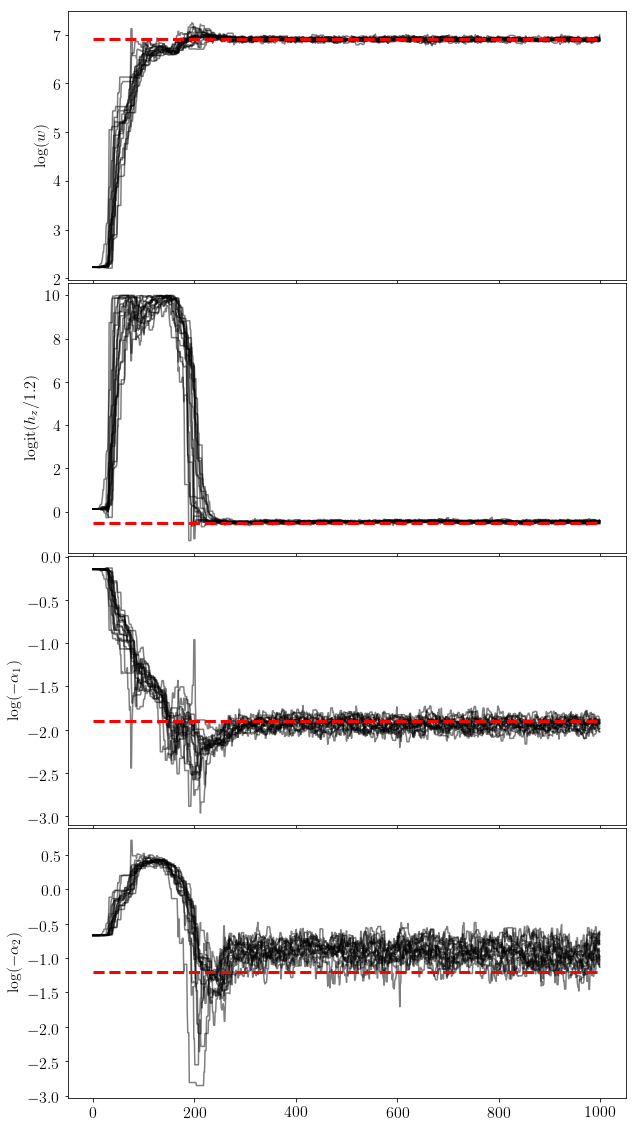

In [254]:
plotting.plot_chains(chains['full_noerr'], truths=true_params, labels=labels)

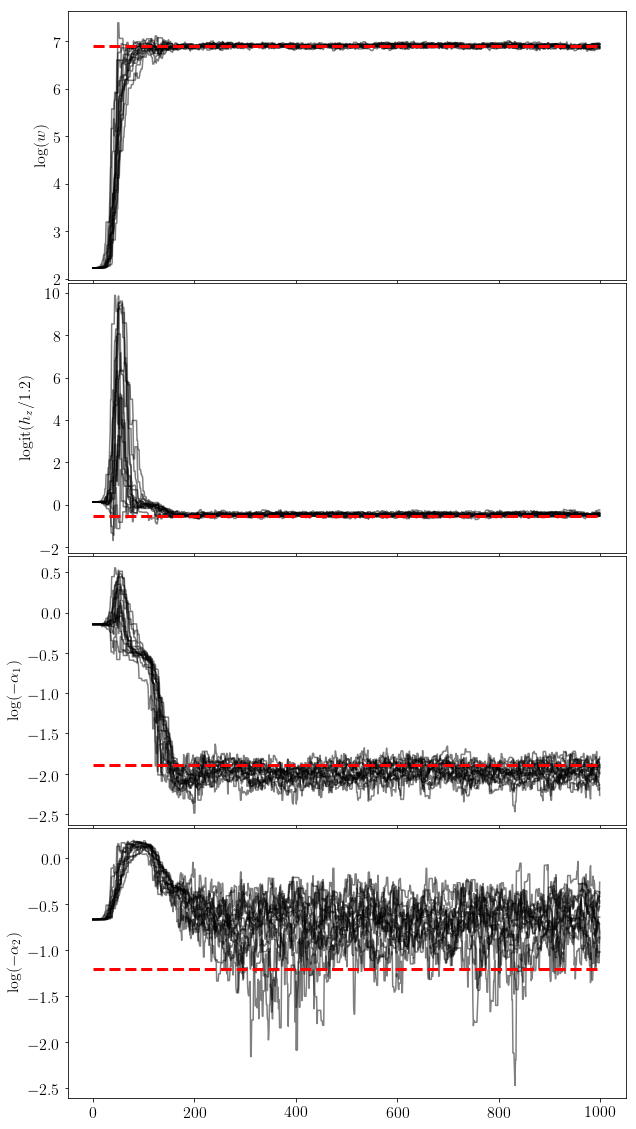

In [255]:
plotting.plot_chains(chains['full_perr'], truths=true_params, labels=labels)